# Evaluate Equivalence between RBAs with different number of edges

## Evaluate the collected indicators

### Load the experiments indicators

In [4]:
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

exp_path = "outputs/exp7_data_7_8_100/"
indicators_file = exp_path + 'data.csv'
df = pd.read_csv(indicators_file)
print("Indicators Loaded")
print(df.dtypes)
df.head(10)

Indicators Loaded
i_sample                    int64
n_local_networks            int64
n_var_network               int64
v_topology                  int64
n_output_variables          int64
n_clauses_function          int64
n_edges                     int64
n_local_attractors          int64
n_pair_attractors           int64
n_attractor_fields          int64
n_time_find_attractors    float64
n_time_find_pairs         float64
n_time_find_fields        float64
dtype: object


,i_sample,n_local_networks,n_var_network,v_topology,n_output_variables,n_clauses_function,n_edges,n_local_attractors,n_pair_attractors,n_attractor_fields,n_time_find_attractors,n_time_find_pairs,n_time_find_fields
0,1,7,5,2,2,2,7,21,16,1,0.719760,0.000244,0.000204
1,1,7,5,2,2,2,8,23,28,9,0.858221,0.000527,0.002359
2,1,7,5,2,2,2,9,25,37,9,0.823539,0.000290,0.002167
3,1,7,5,2,2,2,10,27,44,9,0.809468,0.000324,0.004004
4,1,8,5,2,2,2,8,24,22,1,0.621660,0.000269,0.000695
5,1,8,5,2,2,2,9,26,30,1,0.647386,0.000309,0.000855
6,1,8,5,2,2,2,10,28,49,1,0.688651,0.000329,0.002005
7,1,8,5,2,2,2,11,30,65,1,0.992813,0.000429,0.004161
8,1,8,5,2,2,2,12,32,78,1,1.175072,0.000532,0.010013
9,2,7,5,2,2,2,7,15,8,0,0.878119,0.000256,0.000136


## Filter by local network = 8

In [5]:
# Filter by the number of local networks
n_local_networks = 8
df_filter = df[df['n_local_networks'] == n_local_networks]
num_registers = df_filter.shape[0]
print(f"There are {num_registers} records for RBAs with {n_local_networks} local networks.")

There are 500 records for RBAs with 8 local networks.


### Find the sample with more number of Stable Attractor Fields

In [6]:
# Find the index of the maximum value of 'n_attractor_fields' and get 'i_sample' and 'Number of Edges'
max_sample = df_filter.loc[df_filter['n_attractor_fields'].idxmax(), ['i_sample', 'n_edges']]

# Assign the values of the sample and the number of edges
i_sample_max = int(max_sample['i_sample'])
n_edges_max = int(max_sample['n_edges'])

# Print the result
print(f"The sample with the most attractor fields is {i_sample_max} with {n_edges_max} edges.")

The sample with the most attractor fields is 84 with 12 edges.


### Load the CBN objects for an specific sample

In [7]:
# Define the second number in the pickle file path
i_sample = i_sample_max

# Base path without the changing number
base_path_cbn = f'{exp_path}pkl_cbn/cbn_{int(i_sample)}_{n_local_networks}_'
print(f"Base path is: {base_path_cbn}")

# Initial number and maximum range
start_number = n_local_networks
max_number = 2 * start_number

# List of existing pickle files
pickle_files = [f"{base_path_cbn}{i}.pkl" for i in range(start_number, max_number + 1) if os.path.exists(f"{base_path_cbn}{i}.pkl")]

l_o_cbn = []
# Iterator to load and display the topologies
for path_cbn in pickle_files:
    with open(path_cbn, 'rb') as file:
        o_cbn = pickle.load(file)
        l_o_cbn.append(o_cbn)
        print(f"Loaded {path_cbn}")
print('CBN objects loaded into l_o_cbn')

Base path is: outputs/exp7_data_7_8_100/pkl_cbn/cbn_84_8_
Loaded outputs/exp7_data_7_8_100/pkl_cbn/cbn_84_8_8.pkl
Loaded outputs/exp7_data_7_8_100/pkl_cbn/cbn_84_8_9.pkl
Loaded outputs/exp7_data_7_8_100/pkl_cbn/cbn_84_8_10.pkl
Loaded outputs/exp7_data_7_8_100/pkl_cbn/cbn_84_8_11.pkl
Loaded outputs/exp7_data_7_8_100/pkl_cbn/cbn_84_8_12.pkl
CBN objects loaded into l_o_cbn


### Stable attractor fields for every Global Scene from specific sample 

In [8]:
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

# Función para procesar cada o_cbn individualmente
def process_o_cbn(o_cbn, i_sample, n_local_networks):
    data = {"sample": [], "number_of_local_networks": [], "number_of_edges": [], "global_scene": [], "attractor_fields_count": []}

    num_edges = len(o_cbn.l_directed_edges)
    attractor_fields = o_cbn.get_n_attractor_fields()

    o_cbn.count_fields_by_global_scenes()  # Actualiza datos internos

    dict_global_scenes = o_cbn.get_global_scene_attractor_fields()

    if dict_global_scenes:
        for scene, count in dict_global_scenes.items():
            data["sample"].append(i_sample)
            data["number_of_local_networks"].append(n_local_networks)
            data["number_of_edges"].append(num_edges)
            data["global_scene"].append(scene)
            data["attractor_fields_count"].append(count)

    return data

# Función para ejecutar en cada proceso
def execute_process(o_cbn):
    return process_o_cbn(o_cbn, i_sample, n_local_networks)

# Paralelización usando ProcessPoolExecutor
data = {"sample": [], "number_of_local_networks": [], "number_of_edges": [], "global_scene": [], "attractor_fields_count": []}

with ProcessPoolExecutor() as executor:
    # Ejecuta la función en paralelo para cada o_cbn en l_o_cbn
    results = executor.map(execute_process, l_o_cbn)

    # Combina los resultados de cada ejecución paralela
    for result in results:
        for key in data:
            data[key].extend(result[key])

# Crear DataFrame
df_resume = pd.DataFrame(data)

# format the data
df['n_edges'] = df['n_edges'].astype(int)

# Mostrar el DataFrame en el notebook
df_resume

,sample,number_of_local_networks,number_of_edges,global_scene,attractor_fields_count
0,84,8,8,11111111,1048576
1,84,8,8,11110011,262144
2,84,8,8,00000000,65536
3,84,8,9,111111111,1048576
4,84,8,9,111100111,262144
5,84,8,9,000000000,65536
6,84,8,10,1111001110,262144
7,84,8,10,1111111110,524288
8,84,8,10,1111111111,524288
9,84,8,10,0000000000,65536


### Sum the number attractor fields by edge

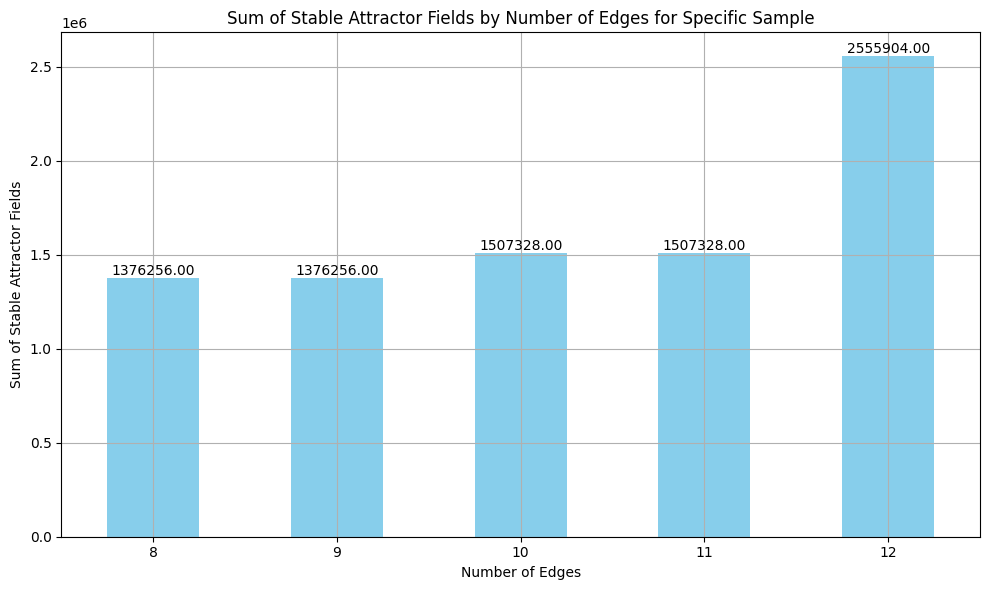

In [6]:
import matplotlib.pyplot as plt

# Group by 'number_of_edges' and sum the 'attractor_fields_count' column
df_suma_attractors = df_resume.groupby('number_of_edges')['attractor_fields_count'].sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = df_suma_attractors.plot(kind='bar', color='skyblue')

# Add values on top of each bar, showing decimals
for i, value in enumerate(df_suma_attractors):
    plt.text(i, value + 0.5, f'{value:.2f}', ha='center', va='bottom')

# Plot configuration
plt.title('Sum of Stable Attractor Fields by Number of Edges for Specific Sample')
plt.xlabel('Number of Edges')
plt.ylabel('Sum of Stable Attractor Fields')
plt.xticks(rotation=0)
plt.grid(True, which='both', axis='both')  # Activate grid for both axes

plt.tight_layout()

# Show plot
plt.show()

### Count the global scenes by edge

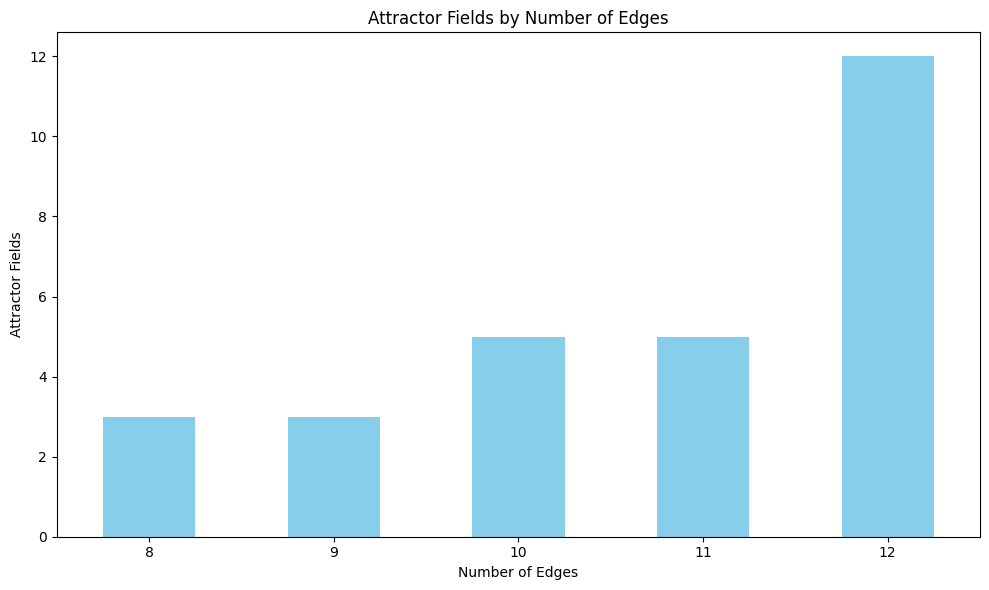

In [7]:
import matplotlib.pyplot as plt

# Group by 'Number of Edges' and count the 'Global Scene' column
df_count_attractors = df_resume.groupby('number_of_edges')['global_scene'].count()

# Create a bar plot
plt.figure(figsize=(10, 6))
df_count_attractors.plot(kind='bar', color='skyblue')

# Plot configuration
plt.title('Attractor Fields by Number of Edges')
plt.xlabel('Number of Edges')
plt.ylabel('Attractor Fields')
plt.xticks(rotation=0)
plt.tight_layout()

# Show plot
plt.show()

### Evaluate the correspondence between global scenes

In [9]:
df_resume.keys()

Index(['sample', 'number_of_local_networks', 'number_of_edges', 'global_scene',
       'attractor_fields_count'],
      dtype='object')

In [25]:
import pandas as pd

# Ordenamos el DataFrame por number_of_edges
df_sorted = df_resume.sort_values(by='number_of_edges')

# Inicializamos una lista para almacenar los resultados
results = []

# Iteramos sobre cada fila del DataFrame ordenado
for idx, row in df_sorted.iterrows():
    current_edges = row['number_of_edges']
    current_scene = row['global_scene']
    current_attractors = row['attractor_fields_count']

    # Encontramos la fila con el número de aristas menor
    prev_rows = df_sorted[(df_sorted['number_of_edges'] < current_edges)]

    # Aseguramos que haya una fila previa
    if not prev_rows.empty:
        prev_row = prev_rows.sort_values(by='number_of_edges').tail(1)
        prev_row = prev_row.iloc[0]

        # Verificamos si la escena previa es realmente parte del current_global_scene
        prev_scene = prev_row['global_scene']
        if prev_scene in current_scene:
            prev_edges = prev_row['number_of_edges']
            prev_attractors = prev_row['attractor_fields_count']

            results.append({
                'current_global_scene': current_scene,
                'current_edges': current_edges,
                'current_attractors': current_attractors,
                'previous_global_scene': prev_scene,
                'previous_edges': prev_edges,
                'previous_attractors': prev_attractors
            })

# Convertimos los resultados a un DataFrame
df_results = pd.DataFrame(results)

# Aseguramos el orden de las columnas como especificaste
df_results = df_results[[
    'current_global_scene', 'previous_global_scene', 'current_edges',
    'previous_edges','current_attractors', 'previous_attractors'
]]

# Mostramos los resultados
df_results

,current_global_scene,previous_global_scene,current_edges,previous_edges,current_attractors,previous_attractors
0,000000000,00000000,9,8,65536,65536
1,0000000000,000000000,10,9,65536,65536
2,00001100011,0000110001,11,10,131072,131072
3,111100111000,11110011100,12,11,262144,262144


In [48]:
import pandas as pd

# Ordenamos el DataFrame por number_of_edges en orden descendente
df_sorted = df_resume.sort_values(by='number_of_edges', ascending=False)

# Inicializamos una lista para almacenar los resultados
results = []

# Iteramos sobre cada fila del DataFrame ordenado
for idx, row in df_sorted.iterrows():
    current_edges = row['number_of_edges']
    current_scene = row['global_scene']
    current_attractors = row['attractor_fields_count']

    # Encontramos las filas con el número de aristas menor
    prev_rows = df_sorted[(df_sorted['number_of_edges'] == current_edges - 1)]

    # Verificamos si hay filas previas
    if not prev_rows.empty:
        for _, prev_row in prev_rows.iterrows():
            prev_scene = prev_row['global_scene']
            # Verificamos si la escena previa es parte del current_global_scene
            if prev_scene in current_scene:
                prev_edges = prev_row['number_of_edges']
                prev_attractors = prev_row['attractor_fields_count']

                results.append({
                    'current_global_scene': current_scene,
                    'previous_global_scene': prev_scene,
                    'current_edges': current_edges,
                    'previous_edges': prev_edges,
                    'current_attractors': current_attractors,
                    'previous_attractors': prev_attractors
                })

# Convertimos los resultados a un DataFrame
df_results = pd.DataFrame(results)

# Aseguramos el orden de las columnas como especificaste
df_results = df_results[[
    'current_global_scene', 'previous_global_scene',
    'current_edges', 'previous_edges',
    'current_attractors', 'previous_attractors'
]]

# Ahora puedes revisar el DataFrame resultante
df_results


,current_global_scene,previous_global_scene,current_edges,previous_edges,current_attractors,previous_attractors
0,111111111111,11111111111,12,11,262144,524288
1,111111111001,11111111100,12,11,262144,524288
2,000011000111,00001100011,12,11,65536,131072
3,000011000110,00001100011,12,11,65536,131072
4,000000000000,00000000000,12,11,65536,65536
5,111111111110,11111111111,12,11,262144,524288
6,111111111000,11111111100,12,11,262144,524288
7,111100111000,11110011100,12,11,262144,262144
8,00001100011,0000110001,11,10,131072,131072
9,00000000000,0000000000,11,10,65536,65536


In [47]:
import pandas as pd

# Ordenamos el DataFrame por number_of_edges en orden descendente
df_sorted = df_resume.sort_values(by='number_of_edges', ascending=False)

# Inicializamos un diccionario para almacenar los resultados
results = {f'Scenes_{i}': [] for i in range(12, 7, -1)}
results.update({f'Edges_{i}': [] for i in range(12, 7, -1)})
results.update({f'Attractors_{i}': [] for i in range(12, 7, -1)})

# Iteramos desde 12 aristas hasta 8 aristas
for num_edges in range(12, 7, -1):
    # Filtramos las escenas actuales con el número de aristas especificado
    current_scenes = df_sorted[df_sorted['number_of_edges'] == num_edges]

    for _, current_row in current_scenes.iterrows():
        current_scene = current_row['global_scene']
        current_attractors = current_row['attractor_fields_count']
        current_edges = current_row['number_of_edges']

        # Inicializamos los valores predeterminados para las columnas
        scenes_prev = [None] * (12 - 8)
        edges_prev = [None] * (12 - 8)
        attractors_prev = [None] * (12 - 8)

        # Encontramos las escenas previas con un número de aristas menor
        for prev_num_edges in range(num_edges - 1, 7, -1):
            prev_scenes = df_sorted[df_sorted['number_of_edges'] == prev_num_edges]

            found = False
            for _, prev_row in prev_scenes.iterrows():
                prev_scene = prev_row['global_scene']
                if prev_scene in current_scene:
                    prev_edges = prev_row['number_of_edges']
                    prev_attractors = prev_row['attractor_fields_count']

                    index = 12 - prev_num_edges - 1
                    scenes_prev[index] = prev_scene
                    edges_prev[index] = prev_edges
                    attractors_prev[index] = prev_attractors

                    found = True
                    break

            if not found:
                index = 12 - prev_num_edges - 1
                scenes_prev[index] = None
                edges_prev[index] = None
                attractors_prev[index] = None

        # Añadimos los resultados al diccionario
        results[f'Scenes_{num_edges}'].append(current_scene)
        results[f'Edges_{num_edges}'].append(current_edges)
        results[f'Attractors_{num_edges}'].append(current_attractors)

        # Añadimos los valores para las escenas previas
        for idx, (scene, edge, attractor) in enumerate(zip(scenes_prev, edges_prev, attractors_prev)):
            results[f'Scenes_{12 - idx - 1}'].append(scene)
            results[f'Edges_{12 - idx - 1}'].append(edge)
            results[f'Attractors_{12 - idx - 1}'].append(attractor)

# Convertimos los resultados a un DataFrame y garantizamos que todas las listas tengan la misma longitud
max_length = max(len(v) for v in results.values())
for key in results:
    while len(results[key]) < max_length:
        results[key].append(None)

df_results = pd.DataFrame(results)

df_results



,Scenes_12,Scenes_11,Scenes_10,Scenes_9,Scenes_8,Edges_12,Edges_11,Edges_10,Edges_9,Edges_8,Attractors_12,Attractors_11,Attractors_10,Attractors_9,Attractors_8
0,111111111111,11111111111,1111111111,111111111,11111111,12.0,11.0,10.0,9.0,8.0,262144.0,524288.0,524288.0,1048576.0,1048576.0
1,111111111001,11111111100,1111111110,111111111,11111111,12.0,11.0,10.0,9.0,8.0,262144.0,524288.0,524288.0,1048576.0,1048576.0
2,000011000111,00001100011,0000110001,None,None,12.0,11.0,10.0,NaN,NaN,65536.0,131072.0,131072.0,NaN,NaN
3,000011000110,00001100011,0000110001,None,None,12.0,11.0,10.0,NaN,NaN,65536.0,131072.0,131072.0,NaN,NaN
4,000000000000,00000000000,0000000000,000000000,00000000,12.0,11.0,10.0,9.0,8.0,65536.0,65536.0,65536.0,65536.0,65536.0
5,111111101111,None,None,None,None,12.0,NaN,NaN,NaN,NaN,262144.0,NaN,NaN,NaN,NaN
6,111111101001,None,None,None,None,12.0,NaN,NaN,NaN,NaN,262144.0,NaN,NaN,NaN,NaN
7,111111000111,None,None,None,None,12.0,NaN,NaN,NaN,NaN,262144.0,NaN,NaN,NaN,NaN
8,111111000001,None,None,None,None,12.0,NaN,NaN,NaN,NaN,262144.0,NaN,NaN,NaN,NaN
9,111111111110,11111111111,1111111111,111111111,11111111,12.0,11.0,10.0,9.0,8.0,262144.0,524288.0,524288.0,1048576.0,1048576.0


In [50]:
import pandas as pd

# Asumiendo que df_resume ya está cargado en tu entorno
# Filtramos las escenas globales con 12 aristas
scenes_12_edges = df_resume[df_resume['number_of_edges'] == 12]

# Mostramos las escenas globales con 12 aristas
scenes_12_edges[['global_scene']]


,global_scene
16,111100111000
17,111111111000
18,111111111110
19,111111000001
20,111111000111
21,111111101001
22,111111101111
23,000000000000
24,000011000110
25,000011000111
